In [20]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
# from dynamic_routing_analysis import decoding_utils
# from dynamic_routing_analysis import plot_utils
# import dynamic_routing_analysis as dra
import pingouin as pg
import os

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
# results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/keep_units_consistent_test_20250605_170828/"
results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/keep_units_consistent_test_20250605_185958/"

In [51]:
# session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.265.csv"
session_table_path="/Users/ethan.mcbride/Data/DR/session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    # pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [52]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'electrode_group_names',
    'unit_subsample_size',
    'bin_center',
    'bin_size',
    'time_aligned_to',
    'coefs',
    'unit_ids',
}

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)


In [53]:
#get single session, keep coefs (and unit ids?)

#include repeats, but don't need predict_proba

#one row per repeat, with coefs and unit ids

### make separate query to include repeats - specify session
sel_session='742903_2024-10-22' #the golden session
# sel_session='670180_2023-07-27' #a templeton session
decoder_coefs = (
    pl.scan_parquet(results_path)
    .filter(
        pl.col('session_id').eq(sel_session),
    )
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),     
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials').not_(),
        
        # pl.col('shift_idx').eq(0)
    )
    # .drop('electrode_group_names', 'is_all_trials', 'is_sole_recording')
    # .group_by(grouping_cols | {'shift_idx'}, maintain_order=True)
    # .agg(
    #     pl.col('balanced_accuracy_test').mean(), # over repeats
    # )
    # # get the aligned result and median over shifts:
    # .group_by(grouping_cols - {'electrode_group_names'})
    # .agg(
    #     pl.col('balanced_accuracy_test').filter(pl.col('shift_idx') == 0).first().alias('mean_true'),
    #     pl.col('balanced_accuracy_test').filter(pl.col('shift_idx') != 0).median().alias('median_null'),
    #     pl.col('balanced_accuracy_test', 'shift_idx').sort_by('shift_idx'),
    # )
    # # get the difference between true and null:
    # .with_columns(
    #     pl.col('mean_true').sub(pl.col('median_null')).alias('mean_diff'),
    # )
    .sort('structure', 'shift_idx', 'repeat_idx', 'time_aligned_to', 'bin_center', descending=False, maintain_order=True)
    .collect()

    # .drop('shift_idx', 'is_all_trials', 'electrode_group_names', 'unit_criteria', 'is_sole_recording')
    # .group_by('session_id', 'structure', 'unit_subsample_size', 'repeat_idx')
    # .agg(
    #     pl.col('balanced_accuracy_test', 'total_n_units').first(),
    #     pl.col('predict_proba', 'trial_index', 'is_vis_context', 'stim_name', 'is_response', 'trial_index_in_block', 'block_index'),
    # )
    # .sort('session_id','structure', 'unit_subsample_size', 'repeat_idx')
    # # .group_by('session_id','structure')
    # .collect()
)

In [54]:
decoder_coefs

balanced_accuracy_test,balanced_accuracy_train,time_aligned_to,bin_size,bin_center,shift_idx,repeat_idx,predict_proba,trial_indices,unit_ids,coefs,is_all_trials,session_id,structure,electrode_group_names,unit_subsample_size,unit_criteria,is_sole_recording
f64,f64,enum,f64,f64,i16,u16,list[f64],list[u16],list[str],list[f64],bool,str,str,list[str],u16,str,bool
0.652029,0.757818,"""stim_start_time""",0.5,-1.25,-43,0,null,null,"[""742903_2024-10-22_A-127"", ""742903_2024-10-22_A-328"", … ""742903_2024-10-22_A-79""]","[0.521531, 0.014124, … -0.619226]",false,"""742903_2024-10-22""","""ACAd""","[""probeA""]",null,"""loose_drift""",true
0.630193,0.77442,"""stim_start_time""",0.5,-0.75,-43,0,null,null,"[""742903_2024-10-22_A-95"", ""742903_2024-10-22_A-366"", … ""742903_2024-10-22_A-365""]","[0.005938, 0.042261, … -0.420054]",false,"""742903_2024-10-22""","""ACAd""","[""probeA""]",null,"""loose_drift""",true
0.623188,0.756123,"""stim_start_time""",0.5,-0.25,-43,0,null,null,"[""742903_2024-10-22_A-94"", ""742903_2024-10-22_A-106"", … ""742903_2024-10-22_A-111""]","[0.236025, -0.012707, … -0.45723]",false,"""742903_2024-10-22""","""ACAd""","[""probeA""]",null,"""loose_drift""",true
0.618599,0.758889,"""stim_start_time""",0.5,0.25,-43,0,null,null,"[""742903_2024-10-22_A-326"", ""742903_2024-10-22_A-102"", … ""742903_2024-10-22_A-85""]","[0.068896, 0.171747, … -0.314964]",false,"""742903_2024-10-22""","""ACAd""","[""probeA""]",null,"""loose_drift""",true
0.643333,0.751108,"""stim_start_time""",0.5,0.75,-43,0,null,null,"[""742903_2024-10-22_A-358"", ""742903_2024-10-22_A-328"", … ""742903_2024-10-22_A-109""]","[0.474754, 0.149302, … -0.427833]",false,"""742903_2024-10-22""","""ACAd""","[""probeA""]",null,"""loose_drift""",true
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.56744,0.758818,"""stim_start_time""",0.5,4.25,44,24,null,null,"[""742903_2024-10-22_E-61"", ""742903_2024-10-22_E-559"", … ""742903_2024-10-22_E-52""]","[0.545426, 0.074064, … -0.062898]",false,"""742903_2024-10-22""","""TTd""","[""probeE""]",null,"""loose_drift""",true
0.498792,0.753874,"""stim_start_time""",0.5,4.75,44,24,null,null,"[""742903_2024-10-22_E-57"", ""742903_2024-10-22_E-66"", … ""742903_2024-10-22_E-54""]","[-0.131496, 0.321597, … 0.285106]",false,"""742903_2024-10-22""","""TTd""","[""probeE"", ""probeF""]",null,"""loose_drift""",false
0.51657,0.73392,"""stim_start_time""",0.5,4.75,44,24,null,null,"[""742903_2024-10-22_E-1005"", ""742903_2024-10-22_E-557"", … ""742903_2024-10-22_E-1219""]","[-0.132133, 0.312828, … 0.020117]",false,"""742903_2024-10-22""","""TTd""","[""probeE""]",null,"""loose_drift""",true


In [55]:
decoder_coefs_pd=decoder_coefs.to_pandas()

In [57]:
# savepath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\keep_units_consistent_test_2025-06-05_170828\decoder_coefs.parquet"
# savepath="/Users/ethan.mcbride/Data/DR/keep_units_consistent_test_2025-06-05_170828/decoder_coefs.parquet"
savepath="/Users/ethan.mcbride/Data/DR/keep_units_consistent_test_20250605_185958/decoder_coefs.parquet"
decoder_coefs_pd.to_parquet(savepath)

In [ ]:
decoder_coefs_pd=pd.read_parquet("/Users/ethan.mcbride/Data/DR/keep_units_consistent_test_2025-06-05_170828/decoder_coefs.parquet")

In [62]:
# for each repeat, 

# get the balanced accuracy test & train, plus the coefs and unit ids across timebins

# check the unit ids are the same across all timebins

# compute the correlation of the coefs to the first timebin


# start with one repeat, one structure

sel_structure='ACAd'
sel_repeat=0
sel_shift_idx=0
# sel_time_bin=-0.25
sel_time_aligned_to='stim_start_time'


In [34]:
# decoder_coefs_pd.query(f'structure == "{sel_structure}" and repeat_idx == {sel_repeat} and time_aligned_to == "{sel_time_aligned_to}"')['unit_ids']
# decoder_coefs_pd.query(f'structure == "{sel_structure}" and bin_center == {sel_time_bin}')

In [63]:
# unit_ids=decoder_coefs_pd.query(f'structure == "{sel_structure}" and repeat_idx == {sel_repeat} and time_aligned_to == "{sel_time_aligned_to}"')['unit_ids']

# unit_ids=decoder_coefs_pd.query(f'structure == "{sel_structure}" and bin_center == {sel_time_bin} and \
#                                 repeat_idx == {sel_repeat} and time_aligned_to == "{sel_time_aligned_to}"')['unit_ids'].values

unit_ids=decoder_coefs_pd.query(f'structure == "{sel_structure}" and shift_idx == {sel_shift_idx} and \
                                repeat_idx == {sel_repeat} and time_aligned_to == "{sel_time_aligned_to}"')['unit_ids'].values

sorted_unit_ids=[]

for uu in unit_ids:
    sorted_unit_ids.append(np.sort(uu))

sorted_unit_ids==sorted_unit_ids[0]

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  Tru

In [40]:
# subsample=np.array([1,3,7,13,20])
# full_array=np.arange(0,30)

# np.where(np.isin(full_array, subsample))[0]
# sel_rows['electrode_group_names'].iloc[0]


In [ ]:
### TODO: deal with multiple probes per area
decoder_coefs_pd['electrode_group_names'].iloc[0]

1

In [ ]:
probestr=''
n_probes=0
for pr in np.array(['probeA','probeB','probeC']):
    probestr=probestr+pr[-1]
    n_probes=n_probes+1

print(probestr,n_probes)

ABC 3


In [124]:
probe_str_list=[]
n_probes_list=[]
for rr, row in decoder_coefs_pd.iterrows():
    n_probes=0
    probe_str=''
    for pr in row['electrode_group_names']:
        probe_str=probe_str+pr[-1]
        n_probes=n_probes+1

    probe_str_list.append(probe_str)
    n_probes_list.append(n_probes)

decoder_coefs_pd['probe']=probe_str_list
decoder_coefs_pd['n_probes']=n_probes_list

In [125]:
decoder_coefs_pd[['electrode_group_names','probe','n_probes']]

,electrode_group_names,probe,n_probes
0,[probeA],A,1
1,[probeA],A,1
2,[probeA],A,1
3,[probeA],A,1
4,[probeA],A,1
...,...,...,...
823195,[probeE],E,1
823196,"[probeE, probeF]",EF,2
823197,[probeE],E,1
823198,"[probeE, probeF]",EF,2


In [ ]:
decoder_coefs_pd.query('structure==@sel_structure')['probe'].unique()

array(['E', 'AEF', 'F', 'A'], dtype=object)

Text(0.5, 1.0, 'ACAd; 742903_2024-10-22; probeA')

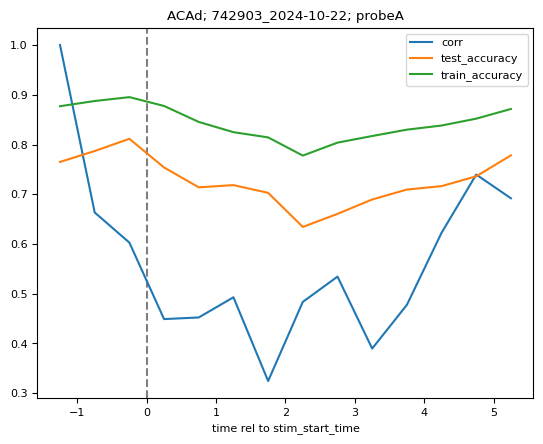

In [140]:
sel_structure='ACAd'
sel_repeat=0
sel_shift_idx=0
# sel_time_bin=-0.25
sel_time_aligned_to='stim_start_time'

#if multiple probes, select the first one
sel_probe_ind=0
unique_probes=decoder_coefs_pd.query('structure==@sel_structure')['probe'].unique()
if len(unique_probes)>sel_probe_ind:
    probe_str=unique_probes[sel_probe_ind]
else:
    probe_str=unique_probes[0]

#select bin index to compare to
sel_comp_ind=0

sel_rows=decoder_coefs_pd.query(f'structure == "{sel_structure}" and shift_idx == {sel_shift_idx} and \
                                repeat_idx == {sel_repeat} and time_aligned_to == "{sel_time_aligned_to}"')

if len(unique_probes)>1:
    sel_rows=sel_rows.query('probe==@probe_str')

corr_coefs=[]

# initial_sort_inds=np.argsort(sel_rows['unit_ids'].values[sel_comp_ind])

initial_coefs=sel_rows['coefs'].values[sel_comp_ind]
initial_unit_ids=sel_rows['unit_ids'].values[sel_comp_ind]
# initial_coefs=sel_rows['coefs'].values[sel_comp_ind][initial_sort_inds]
# initial_unit_ids=sel_rows['unit_ids'].values[sel_comp_ind][initial_sort_inds]

for idx, row in sel_rows.iterrows():
    
    # sort_inds=np.argsort(row['unit_ids'])
    unit_ids=np.sort(row['unit_ids'])
    coefs=row['coefs']
    # unit_ids=row['unit_ids'][sort_inds]
    # coefs=row['coefs'][sort_inds]
    
    if np.array_equal(np.sort(initial_unit_ids), unit_ids):
    # if np.array_equal(initial_unit_ids, unit_ids):
        corr_coefs.append(np.corrcoef(initial_coefs, coefs)[0,1])
    else:
        print(f"Unit ids in time bin {row['bin_center']} do not match initial bin in \n repeat {sel_repeat}, structure {sel_structure}, shift_idx {sel_shift_idx}, time_aligned_to {sel_time_aligned_to}")
        corr_coefs.append(np.nan)


fig,ax=plt.subplots(1,1)
ax.axvline(0,color='k',linestyle='--',alpha=0.5)
ax.plot(sel_rows['bin_center'],np.array(corr_coefs),label='corr')
ax.plot(sel_rows['bin_center'],sel_rows['balanced_accuracy_test'],label='test_accuracy')
ax.plot(sel_rows['bin_center'],sel_rows['balanced_accuracy_train'],label='train_accuracy')

ax.legend()
ax.set_xlabel('time rel to '+sel_time_aligned_to)
ax.set_title(sel_structure+'; '+sel_session+'; probe'+probe_str)